In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PyCO2SYS as pyco2
import cartopy.crs as ccrs
import string

df_compilation = pd.read_csv("../../compilation/data/in_situ_rates_compiled_allvar.csv")

df_all = pd.read_csv("data/glodap22_recent_withWOA.csv")

# get CANYON-B results
glodap_woa_cb = pd.read_csv("data/glodap22_recent_canyonb_results.csv")

df_all["Alk_woa_cb"] = glodap_woa_cb['Alkalinity']
df_all["DIC_woa_cb"] = glodap_woa_cb['DIC']
df_all["Nitrate_woa_cb"] = glodap_woa_cb["Nitrate"]
df_all["PO4_woa_cb"] = glodap_woa_cb["Phosphate"]
df_all["SiOH4_woa_cb"] = glodap_woa_cb["Silicate"]
df_all["pH_insitu_woa_cb"] = glodap_woa_cb["pH"]

# remove all rows where I didn't/couldn't do WOA + CANYON-B
df_all = df_all.dropna(axis=0)
print(df_all.shape)

# remove all cruises that had adjustments
df_all = df_all[~df_all['G2expocode'].isin(['33RO20161119', '096U20180111', '320620180309', '18DL20200722'])]
df_all.shape


def makemap(dataframe):    
    recent_stations_lat = []
    recent_stations_lon = []

    for cruise in dataframe['G2expocode'].unique():
        glodap22_cruise = dataframe[dataframe['G2expocode'] == cruise]
        for station in glodap22_cruise['G2station'].unique():
            glodap22_cruise_station = glodap22_cruise[glodap22_cruise['G2station'] == station]

            recent_stations_lat.append(glodap22_cruise_station['G2latitude'].values[0])
            recent_stations_lon.append(glodap22_cruise_station['G2longitude'].values[0])

    plt.figure(dpi=200)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.stock_img()
    plt.scatter(recent_stations_lon, recent_stations_lat, color='red', s=0.1)
    plt.scatter(df_compilation['Longitude'].unique(), df_compilation['Latitude'].unique(), color='blue', s=2)
    gl = ax.gridlines(draw_labels=True, alpha=0.5)
    gl.xlabel_style = {'size': 5, 'color': 'gray'}
    gl.ylabel_style = {'size': 5, 'color': 'gray'}
    plt.show()
    
    

(39943, 30)


## Sea of Japan is not predicted well (Figure S1)

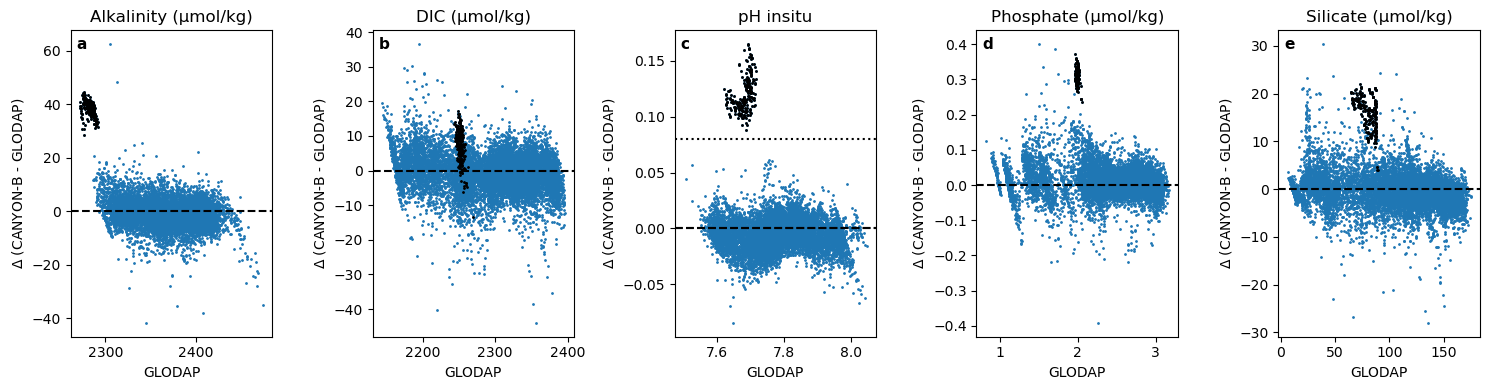

In [2]:
# select all data below 1000 m
df_all_deep = df_all[df_all['G2depth'] > 1000]

#isolate Sea of Japan
japan_expocodes = df_all_deep[(df_all_deep['pH_insitu_woa_cb'] - df_all_deep['G2phtsinsitutp'] > 0.08)]['G2expocode'].unique()
df_japan = df_all[df_all['G2expocode'].isin(japan_expocodes)]
df_japan_deep = df_japan[df_japan['G2depth'] > 1000]

# also make dataset without the Sea of Japan
df = df_all[~df_all['G2expocode'].isin(japan_expocodes)].copy()

# make figure
fig, axs = plt.subplots(nrows=1,ncols=5, figsize=(15,4))

for a in axs:
    a.set_ylabel('$\Delta$ (CANYON-B - GLODAP)')
    a.set_xlabel('GLODAP')

axs[0].scatter(df_all_deep['G2talk'], df_all_deep['Alk_woa_cb'] - df_all_deep['G2talk'], s=1, label='WOA(T,S,O2)')
axs[0].scatter(df_japan_deep['G2talk'], df_japan_deep['Alk_woa_cb'] - df_japan_deep['G2talk'], 
               s=1, label='WOA(T,S,O2)', color='black')
axs[0].axline((2300,0), slope=0, color='black', linestyle='--')

#axs[0].set_ylim(-30,50)
axs[0].set_title('Alkalinity (µmol/kg)')

axs[1].scatter(df_all_deep['G2tco2'], df_all_deep['DIC_woa_cb'] - df_all_deep['G2tco2'], s=1)
axs[1].scatter(df_japan_deep['G2tco2'], df_japan_deep['DIC_woa_cb'] - df_japan_deep['G2tco2'], s=1, color='black')
axs[1].axline((2300,0), slope=0, color='black', linestyle='--')
#axs[1].set_ylim(-30,50)
axs[1].set_title('DIC (µmol/kg)')

axs[2].scatter(df_all_deep['G2phtsinsitutp'], df_all_deep['pH_insitu_woa_cb'] - df_all_deep['G2phtsinsitutp'], s=1)
axs[2].scatter(df_japan_deep['G2phtsinsitutp'], df_japan_deep['pH_insitu_woa_cb'] - df_japan_deep['G2phtsinsitutp'], 
               s=1, color='black')
axs[2].axline((7.5,0), slope=0, color='black', linestyle='--')
axs[2].axline((7.5,0), slope=0, color='black', linestyle='--')
axs[2].axline((7.5,0.08), slope=0, color='black', linestyle='dotted')
#axs[2].axline((7.5,-0.09), slope=0, color='black', linestyle='dotted')
axs[2].set_title('pH insitu')

axs[3].scatter(df_all_deep['G2phosphate'], df_all_deep['PO4_woa_cb'] - df_all_deep['G2phosphate'], s=1)
axs[3].scatter(df_japan_deep['G2phosphate'], df_japan_deep['PO4_woa_cb'] - df_japan_deep['G2phosphate'], s=1, color='black')
axs[3].axline((2,0), slope=0, color='black', linestyle='--')
axs[3].set_title('Phosphate (µmol/kg)')

axs[4].scatter(df_all_deep['G2silicate'], df_all_deep['SiOH4_woa_cb'] - df_all_deep['G2silicate'], s=1)
axs[4].scatter(df_japan_deep['G2silicate'], df_japan_deep['SiOH4_woa_cb'] - df_japan_deep['G2silicate'], s=1, color='black')
axs[4].axline((7.5,0), slope=0, color='black', linestyle='--')
axs[4].set_title('Silicate (µmol/kg)')

#plt.suptitle('CANYON-B estimates vs recent GLODAPv2.2022 cruise measurements (> 1000 m)', fontsize=14)

for n,ax in enumerate(axs.flatten()):
    ax.annotate(string.ascii_lowercase[n], (0.03, 0.94), xycoords='axes fraction', weight='bold', fontsize=11)

plt.tight_layout()
plt.show()

## Map of selected cruises (Figure S2)

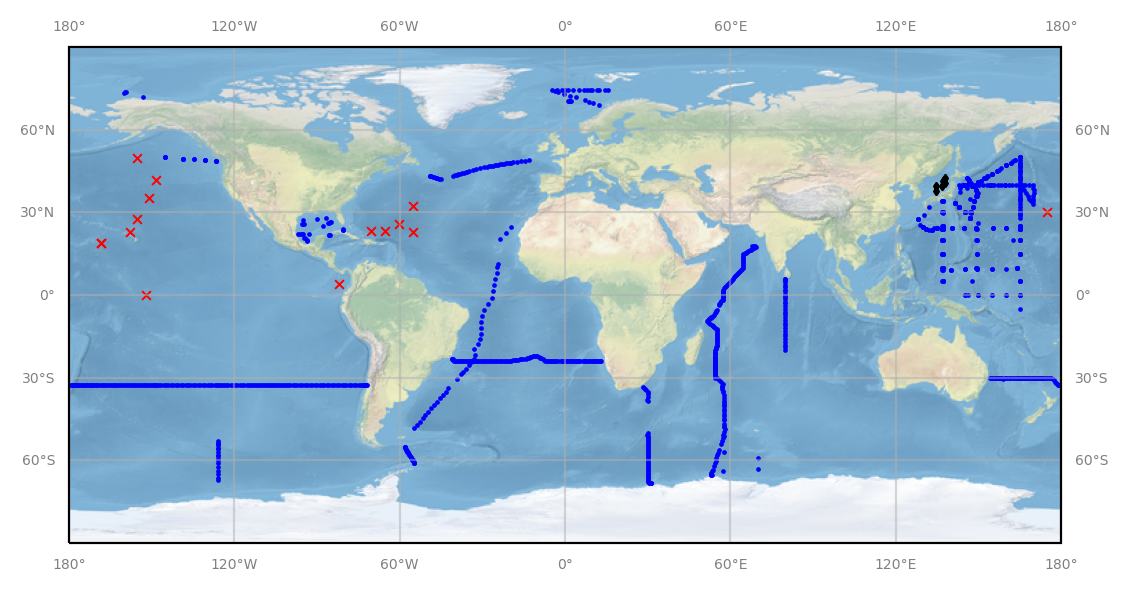

In [3]:
plt.figure(dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

# plot all stations that are used
recent_stations_lat, recent_stations_lon = [], []
for cruise in df['G2expocode'].unique():
    glodap22_cruise = df[df['G2expocode'] == cruise]
    for station in glodap22_cruise['G2station'].unique():
        glodap22_cruise_station = glodap22_cruise[glodap22_cruise['G2station'] == station]

        recent_stations_lat.append(glodap22_cruise_station['G2latitude'].values[0])
        recent_stations_lon.append(glodap22_cruise_station['G2longitude'].values[0])
plt.scatter(recent_stations_lon, recent_stations_lat, color='blue', s=0.5)

# plot cruises in Sea of Japan
recent_stations_lat, recent_stations_lon = [], []
for cruise in japan_expocodes:
    glodap22_cruise = df_japan[df_japan['G2expocode'] == cruise]
    for station in glodap22_cruise['G2station'].unique():
        glodap22_cruise_station = glodap22_cruise[glodap22_cruise['G2station'] == station]

        recent_stations_lat.append(glodap22_cruise_station['G2latitude'].values[0])
        recent_stations_lon.append(glodap22_cruise_station['G2longitude'].values[0])        
plt.scatter(recent_stations_lon, recent_stations_lat, color='black', s=2, marker='d')

# plot dissolution experiments
plt.scatter(df_compilation['Longitude'].unique(), df_compilation['Latitude'].unique(), color='red', 
            s=10, marker='x', linewidth=0.7)
gl = ax.gridlines(draw_labels=True, alpha=0.5)
gl.xlabel_style = {'size': 5, 'color': 'gray'}
gl.ylabel_style = {'size': 5, 'color': 'gray'}
plt.show()

In [4]:
print(df.shape)

df_deep = df[df['G2depth'] > 1000]
print(df_deep.shape)

(31670, 30)
(14536, 30)


# WOA comparison (Figure S3)

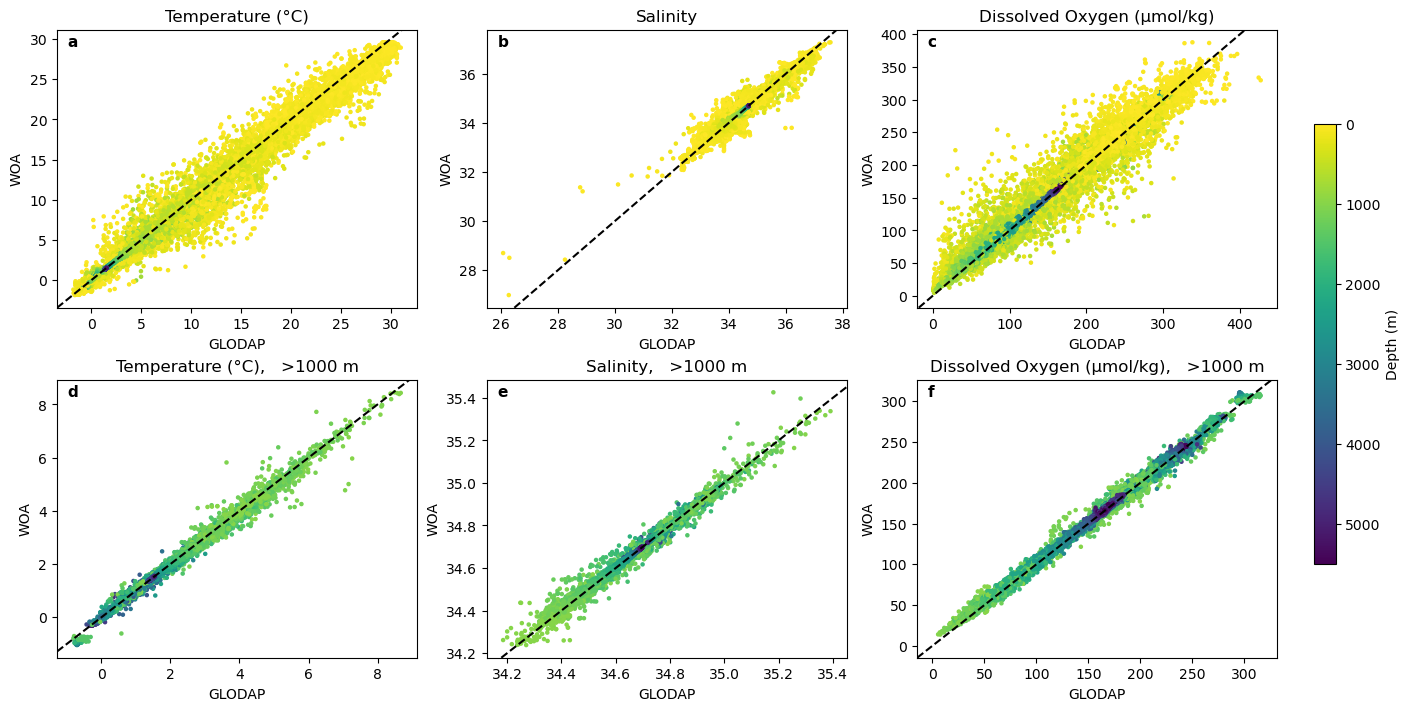

In [5]:
df_deep = df[df['G2depth'] > 1000]

fig, axs = plt.subplots(nrows=2,ncols=3, figsize=(14,7), layout='compressed')


for a in axs.flatten():
    a.set_ylabel('WOA')
    a.set_xlabel('GLODAP')
    
axs[0,0].scatter(df['G2temperature'], df['Temp_WOA'], c=df['G2depth'], cmap='viridis_r', s=5)
axs[0,0].axline((1,1), slope=1, color='black', linestyle='--')
axs[0,0].set_title('Temperature (°C)')

axs[0,1].scatter(df['G2salinity'], df['Sal_WOA'], c=df['G2depth'], cmap='viridis_r', s=5)
axs[0,1].axline((35,35), slope=1, color='black', linestyle='--')
axs[0,1].set_title('Salinity')

axs[0,2].scatter(df['G2oxygen'], df['Doxy_WOA'], c=df['G2depth'], cmap='viridis_r', s=5)
axs[0,2].axline((1,1), slope=1, color='black', linestyle='--')
axs[0,2].set_title('Dissolved Oxygen (µmol/kg)')


axs[1,0].scatter(df_deep['G2temperature'], df_deep['Temp_WOA'], c=df_deep['G2depth'], cmap='viridis_r', s=5, vmin=0)
axs[1,0].axline((1,1), slope=1, color='black', linestyle='--')
axs[1,0].set_title('Temperature (°C),   >1000 m')

axs[1,1].scatter(df_deep['G2salinity'], df_deep['Sal_WOA'], c=df_deep['G2depth'], cmap='viridis_r', s=5, vmin=0)
axs[1,1].axline((35,35), slope=1, color='black', linestyle='--')
axs[1,1].set_title('Salinity,   >1000 m')

cb = axs[1,2].scatter(df_deep['G2oxygen'], df_deep['Doxy_WOA'], c=df_deep['G2depth'], cmap='viridis_r', s=5, vmin=0)
axs[1,2].axline((1,1), slope=1, color='black', linestyle='--')
axs[1,2].set_title('Dissolved Oxygen (µmol/kg),   >1000 m')


cbar = fig.colorbar(cb, ax=axs, label='Depth (m)', shrink=0.7, pad=0.03) 
cbar.ax.invert_yaxis()

for n,ax in enumerate(axs.flatten()):
    ax.annotate(string.ascii_lowercase[n], (0.03, 0.94), xycoords='axes fraction', weight='bold', fontsize=11)

#plt.suptitle('WOA vs cruise measurements', fontsize=14)

#plt.tight_layout()
plt.show()

# CANYON-B comparison (Figure S4)

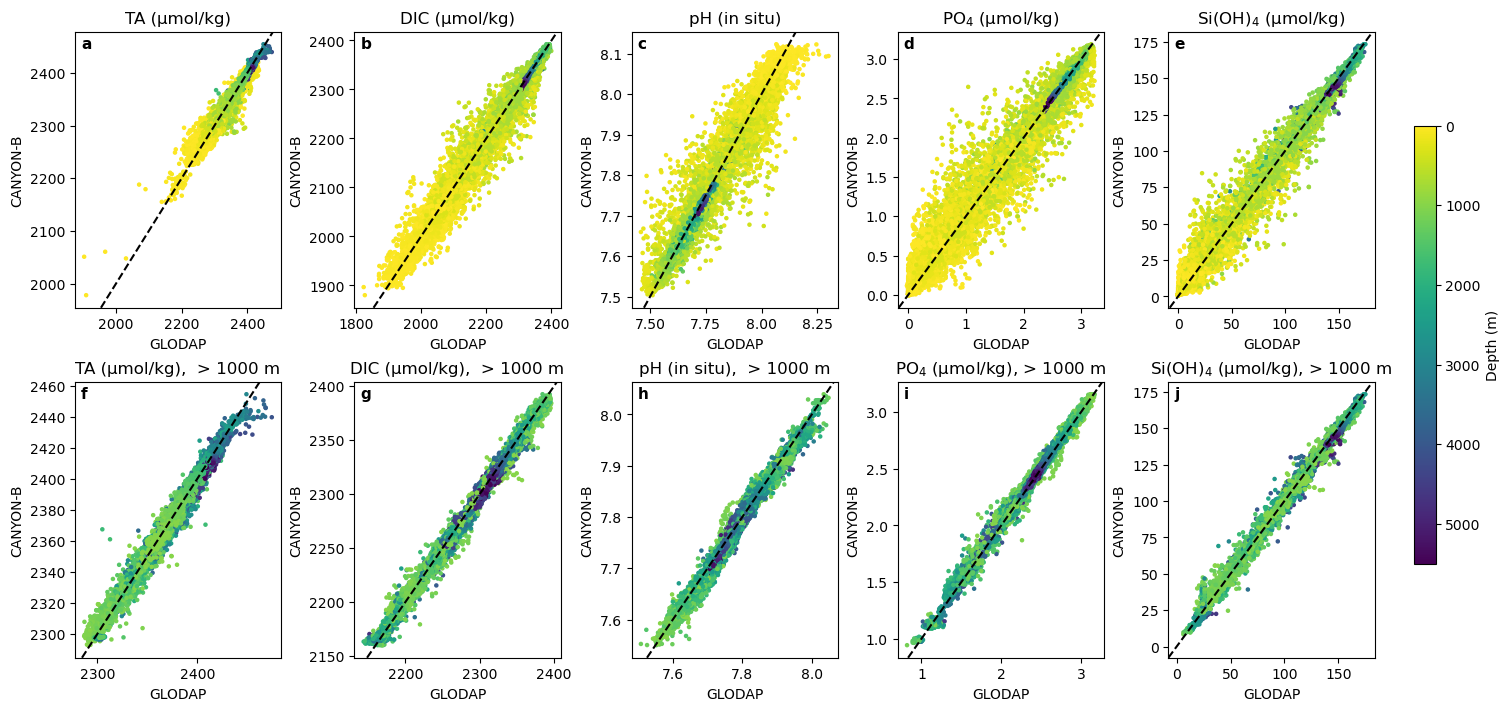

In [6]:
df_deep = df[df['G2depth'] > 1000]

fig, axs = plt.subplots(nrows=2,ncols=5, figsize=(15,7), layout='compressed')


for a in axs.flatten():
    a.set_ylabel('CANYON-B')
    a.set_xlabel('GLODAP')
    
axs[0,0].scatter(df['G2talk'], df['Alk_woa_cb'], c=df['G2depth'], cmap='viridis_r', s=5)
axs[0,0].axline((2400,2400), slope=1, color='black', linestyle='--')
axs[0,0].set_title('TA (µmol/kg)')

axs[0,1].scatter(df['G2tco2'], df['DIC_woa_cb'], c=df['G2depth'], cmap='viridis_r', s=5)
axs[0,1].axline((2300,2300), slope=1, color='black', linestyle='--')
axs[0,1].set_title('DIC (µmol/kg)')

axs[0,2].scatter(df['G2phtsinsitutp'], df['pH_insitu_woa_cb'], c=df['G2depth'], cmap='viridis_r', s=5)
axs[0,2].axline((7.8,7.8), slope=1, color='black', linestyle='--')
axs[0,2].set_title('pH (in situ)')

axs[0,3].scatter(df['G2phosphate'], df['PO4_woa_cb'], c=df['G2depth'], cmap='viridis_r', s=5)
axs[0,3].axline((1,1), slope=1, color='black', linestyle='--')
axs[0,3].set_title('PO$_4$ (µmol/kg)')

axs[0,4].scatter(df['G2silicate'], df['SiOH4_woa_cb'], c=df['G2depth'], cmap='viridis_r', s=5)
axs[0,4].axline((1,1), slope=1, color='black', linestyle='--')
axs[0,4].set_title('Si(OH)$_4$ (µmol/kg)')


axs[1,0].scatter(df_deep['G2talk'], df_deep['Alk_woa_cb'], c=df_deep['G2depth'], cmap='viridis_r', s=5, vmin=0)
axs[1,0].axline((2400,2400), slope=1, color='black', linestyle='--')
axs[1,0].set_title('TA (µmol/kg),  > 1000 m')

axs[1,1].scatter(df_deep['G2tco2'], df_deep['DIC_woa_cb'], c=df_deep['G2depth'], cmap='viridis_r', s=5, vmin=0)
axs[1,1].axline((2300,2300), slope=1, color='black', linestyle='--')
axs[1,1].set_title('DIC (µmol/kg),  > 1000 m')

axs[1,2].scatter(df_deep['G2phtsinsitutp'], df_deep['pH_insitu_woa_cb'], c=df_deep['G2depth'], cmap='viridis_r', s=5, vmin=0)
axs[1,2].axline((7.8,7.8), slope=1, color='black', linestyle='--')
axs[1,2].set_title('pH (in situ),  > 1000 m')

axs[1,3].scatter(df_deep['G2phosphate'], df_deep['PO4_woa_cb'], c=df_deep['G2depth'], cmap='viridis_r', s=5, vmin=0)
axs[1,3].axline((1,1), slope=1, color='black', linestyle='--')
axs[1,3].set_title('PO$_4$ (µmol/kg), > 1000 m')

cb = axs[1,4].scatter(df_deep['G2silicate'], df_deep['SiOH4_woa_cb'], c=df_deep['G2depth'], cmap='viridis_r', s=5, vmin=0)
axs[1,4].axline((1,1), slope=1, color='black', linestyle='--')
axs[1,4].set_title('Si(OH)$_4$ (µmol/kg), > 1000 m')


cbar = fig.colorbar(cb, ax=axs, label='Depth (m)', shrink=0.7, pad=0.03) 
cbar.ax.invert_yaxis()

for n,ax in enumerate(axs.flatten()):
    ax.annotate(string.ascii_lowercase[n], (0.03, 0.94), xycoords='axes fraction', weight='bold', fontsize=11)

#plt.tight_layout()
plt.show()

# Omega

In [7]:
df.columns

Index(['G2expocode', 'G2station', 'G2maxsampdepth', 'G2cast', 'G2year',
       'G2month', 'G2longitude', 'G2latitude', 'G2pressure', 'G2depth',
       'G2temperature', 'G2salinity', 'G2oxygen', 'G2nitrate', 'G2silicate',
       'G2phosphate', 'G2talk', 'G2tco2', 'G2phtsinsitutp', 'Temp_WOA',
       'Sal_WOA', 'Doxy_WOA', 'PO4_WOA', 'SiOH4_WOA', 'Alk_woa_cb',
       'DIC_woa_cb', 'Nitrate_woa_cb', 'PO4_woa_cb', 'SiOH4_woa_cb',
       'pH_insitu_woa_cb'],
      dtype='object')

In [8]:
# original (measured) data
df['Oca_g2_calc12'] = pyco2.sys(par1=df["G2talk"], par2=df["G2tco2"], par1_type = 1, par2_type=2, 
                       salinity=df["G2salinity"], temperature=df["G2temperature"], pressure=df["G2pressure"],
                       total_silicate=df["G2silicate"], total_phosphate=df["G2phosphate"])['saturation_calcite']

df['Oca_g2_calc13'] = pyco2.sys(par1=df["G2talk"], par2=df["G2phtsinsitutp"], par1_type = 1, par2_type=3, 
                       salinity=df["G2salinity"], temperature=df["G2temperature"], pressure=df["G2pressure"],
                       total_silicate=df["G2silicate"], total_phosphate=df["G2phosphate"])['saturation_calcite']


df['Oca_g2_calc23'] = pyco2.sys(par1=df["G2tco2"], par2=df["G2phtsinsitutp"], par1_type = 2, par2_type=3, 
                       salinity=df["G2salinity"], temperature=df["G2temperature"], pressure=df["G2pressure"],
                       total_silicate=df["G2silicate"], total_phosphate=df["G2phosphate"])['saturation_calcite']


# WOA + CANYON-B
df['Oca_woa_cb_calc12'] = pyco2.sys(par1=df["Alk_woa_cb"], par2=df["DIC_woa_cb"], par1_type = 1, par2_type=2, 
                       salinity=df["Sal_WOA"], temperature=df["Temp_WOA"], pressure=df["G2pressure"],
                       total_silicate=df["SiOH4_woa_cb"], total_phosphate=df["PO4_woa_cb"])['saturation_calcite']

df['Oca_woa_cb_calc13'] = pyco2.sys(par1=df["Alk_woa_cb"], par2=df["pH_insitu_woa_cb"], par1_type = 1, par2_type=3, 
                       salinity=df["Sal_WOA"], temperature=df["Temp_WOA"], pressure=df["G2pressure"],
                       total_silicate=df["SiOH4_woa_cb"], total_phosphate=df["PO4_woa_cb"])['saturation_calcite']


df['Oca_woa_cb_calc23'] = pyco2.sys(par1=df["DIC_woa_cb"], par2=df["pH_insitu_woa_cb"], par1_type = 2, par2_type=3, 
                       salinity=df["Sal_WOA"], temperature=df["Temp_WOA"], pressure=df["G2pressure"],
                       total_silicate=df["SiOH4_woa_cb"], total_phosphate=df["PO4_woa_cb"])['saturation_calcite']


### Figure S5

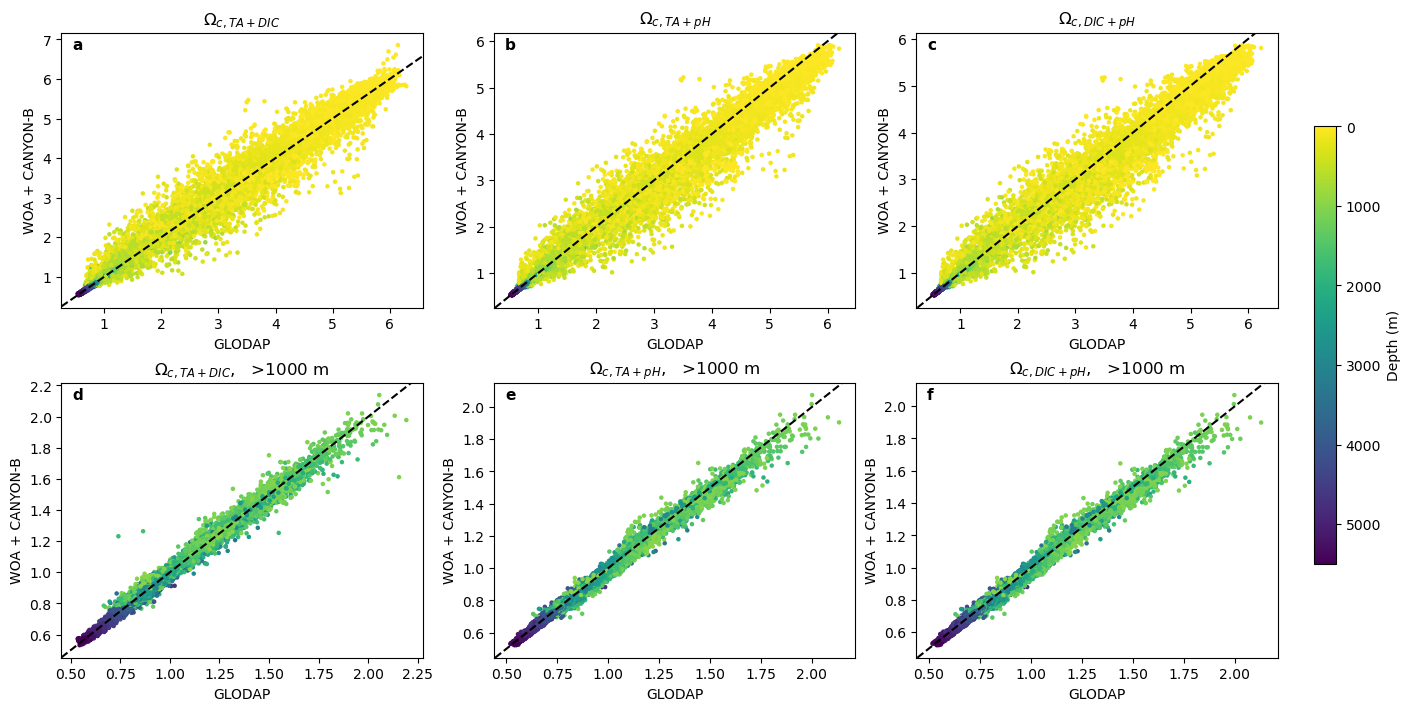

In [9]:
df_deep = df[df['G2depth'] > 1000]

fig, axs = plt.subplots(nrows=2,ncols=3, figsize=(14,7), layout='compressed')


for a in axs.flatten():
    a.set_ylabel('WOA + CANYON-B')
    a.set_xlabel('GLODAP')
    
axs[0,0].scatter(df['Oca_g2_calc12'], df['Oca_woa_cb_calc12'], c=df['G2depth'], cmap='viridis_r', s=5)
axs[0,0].axline((1,1), slope=1, color='black', linestyle='--')
axs[0,0].set_title('$\Omega_{c, TA + DIC}$')

axs[0,1].scatter(df['Oca_g2_calc13'], df['Oca_woa_cb_calc13'], c=df['G2depth'], cmap='viridis_r', s=5)
axs[0,1].axline((1,1), slope=1, color='black', linestyle='--')
axs[0,1].set_title('$\Omega_{c, TA + pH}$')

axs[0,2].scatter(df['Oca_g2_calc23'], df['Oca_woa_cb_calc23'], c=df['G2depth'], cmap='viridis_r', s=5)
axs[0,2].axline((1,1), slope=1, color='black', linestyle='--')
axs[0,2].set_title('$\Omega_{c, DIC + pH}$')


axs[1,0].scatter(df_deep['Oca_g2_calc12'], df_deep['Oca_woa_cb_calc12'], c=df_deep['G2depth'], cmap='viridis_r', s=5, vmin=0)
axs[1,0].axline((1,1), slope=1, color='black', linestyle='--')
axs[1,0].set_title('$\Omega_{c, TA + DIC}$,   >1000 m')

axs[1,1].scatter(df_deep['Oca_g2_calc13'], df_deep['Oca_woa_cb_calc13'], c=df_deep['G2depth'], cmap='viridis_r', s=5, vmin=0)
axs[1,1].axline((1,1), slope=1, color='black', linestyle='--')
axs[1,1].set_title('$\Omega_{c, TA + pH}$,   >1000 m')

cb = axs[1,2].scatter(df_deep['Oca_g2_calc23'], df_deep['Oca_woa_cb_calc23'], c=df_deep['G2depth'], cmap='viridis_r', s=5, vmin=0)
axs[1,2].axline((1,1), slope=1, color='black', linestyle='--')
axs[1,2].set_title('$\Omega_{c, DIC + pH}$,   >1000 m')


cbar = fig.colorbar(cb, ax=axs, label='Depth (m)', shrink=0.7, pad=0.03) 
cbar.ax.invert_yaxis()

for n,ax in enumerate(axs.flatten()):
    ax.annotate(string.ascii_lowercase[n], (0.03, 0.94), xycoords='axes fraction', weight='bold', fontsize=11)

#plt.suptitle('WOA vs cruise measurements', fontsize=14)

#plt.tight_layout()
plt.show()

### Offset $\Omega$ with different parameter pairs (Figure S6)

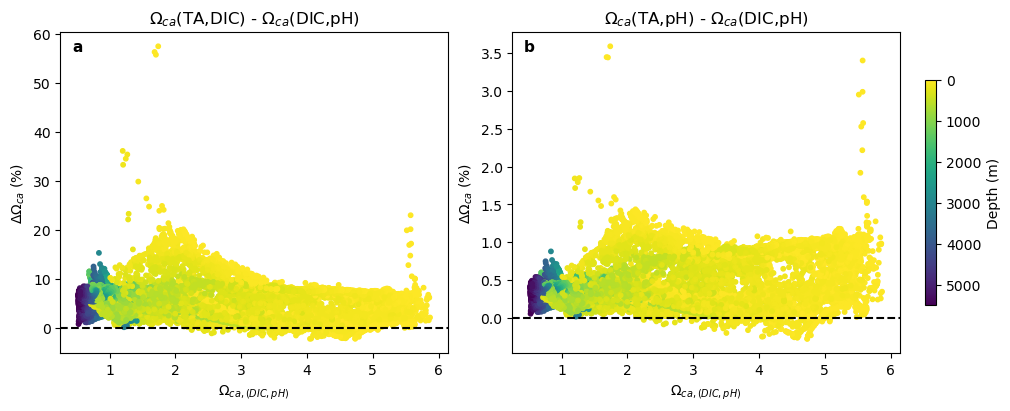

In [10]:
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(10,4), layout='compressed')

axs[0].scatter(df['Oca_woa_cb_calc23'], 
            (df['Oca_woa_cb_calc12']-df['Oca_woa_cb_calc23'])*100/df['Oca_woa_cb_calc23'], 
            c=df['G2depth'], cmap='viridis_r', s=10, vmin=0)
axs[0].axline((1,0), slope=0, color='black', linestyle='--')
axs[0].set_title('$\Omega_{ca}$(TA,DIC) - $\Omega_{ca}$(DIC,pH)')


cb = axs[1].scatter(df['Oca_woa_cb_calc23'], 
            (df['Oca_woa_cb_calc13']-df['Oca_woa_cb_calc23'])*100/df['Oca_woa_cb_calc23'], 
            c=df['G2depth'], cmap='viridis_r', s=10, vmin=0)
axs[1].axline((1,0), slope=0, color='black', linestyle='--')
axs[1].set_title('$\Omega_{ca}$(TA,pH) - $\Omega_{ca}$(DIC,pH)')


for a in axs.flatten():
    a.set_ylabel('$\Delta  \Omega_{ca}$ (%)')
    a.set_xlabel('$\Omega_{ca,(DIC,pH)}$')
    
cbar = fig.colorbar(cb, ax=axs, label='Depth (m)', shrink=0.7, pad=0.03) 
cbar.ax.invert_yaxis()
    
    
for n,ax in enumerate(axs.flatten()):
    ax.annotate(string.ascii_lowercase[n], (0.03, 0.94), xycoords='axes fraction', weight='bold', fontsize=11)



plt.show()

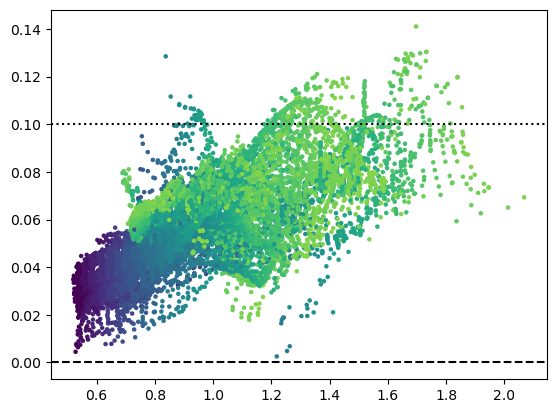

In [11]:
plt.scatter(df_deep['Oca_woa_cb_calc23'], df_deep['Oca_woa_cb_calc12']-df_deep['Oca_woa_cb_calc23'], 
            c=df_deep['G2depth'], cmap='viridis_r', s=5, vmin=0)
plt.axline((1,0), slope=0, color='black', linestyle='--')
plt.axline((1,0.1), slope=0, color='black', linestyle='dotted')
plt.show()

# Do some stats (Table S1)

In [12]:
import sklearn.metrics as metrics

df_surface = df[df['G2depth'] <= 1000]

g2_dict = {'Alk': 'G2talk',
           'DIC': 'G2tco2',
           'pH': 'G2phtsinsitutp',
           'Temp': 'G2temperature',
           'Sal': 'G2salinity',
           'O2': 'G2oxygen',
           'Oca_calc12': 'Oca_g2_calc12',
           'Oca_calc13': 'Oca_g2_calc13',
           'Oca_calc23': 'Oca_g2_calc23',
           'PO4': 'G2phosphate',
           'SiOH4': 'G2silicate'}

woa_cb_dict = {'Alk': 'Alk_woa_cb',
               'DIC': 'DIC_woa_cb',
               'pH': 'pH_insitu_woa_cb',
               'Temp': 'Temp_WOA',
               'Sal': 'Sal_WOA',
               'O2': 'Doxy_WOA',
               'Oca_calc12': 'Oca_woa_cb_calc12',
               'Oca_calc13': 'Oca_woa_cb_calc13',
               'Oca_calc23': 'Oca_woa_cb_calc23',
               'PO4': 'PO4_woa_cb',
               'SiOH4': 'SiOH4_woa_cb'}


def get_stats(var, deep = False, surface = False):
    
    if surface == False:
        y = df_deep[g2_dict[var]]
        ypred = df_deep[woa_cb_dict[var]]
    elif deep == False:
        y = df_surface[g2_dict[var]]
        ypred = df_surface[woa_cb_dict[var]]
    else:
        y = df[g2_dict[var]]
        ypred = df[woa_cb_dict[var]]

    mae = metrics.mean_absolute_error(y, ypred)
    mse = metrics.mean_squared_error(y, ypred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(y,ypred)
    
    return round(mae,2), round(rmse,2), round(r2,2)

In [13]:
varss = ['Temp', 'Sal', 'O2', 'Alk', 'DIC', 'pH', 'PO4', 'SiOH4', 'Oca_calc12', 'Oca_calc13', 'Oca_calc23']


df_stats = pd.DataFrame(data={'Variables': varss})

for n,stat in enumerate(['MAE', 'RMSE', 'R2']):
    a = []
    for i in varss:
        a.append(get_stats(i, deep=True, surface=True)[n])
    df_stats[stat] = a
    
    
for n,stat in enumerate(['MAE_deep', 'RMSE_deep', 'R2_deep']):
    a = []
    for i in varss:
        a.append(get_stats(i, deep=True)[n])
    df_stats[stat] = a
    
    
#for n,stat in enumerate(['MAE_surface', 'RMSE_surface', 'R2_surface']):
#    a = []
#    for i in varss:
#        a.append(get_stats(i, surface=True)[n])
#    df_stats[stat] = a
    
df_stats

,Variables,MAE,RMSE,R2,MAE_deep,RMSE_deep,R2_deep
0,Temp,0.48,0.98,0.98,0.06,0.12,0.99
1,Sal,0.06,0.13,0.94,0.01,0.01,0.99
2,O2,7.50,13.64,0.96,3.00,4.36,0.99
3,Alk,5.03,7.78,0.98,3.17,4.32,0.99
4,DIC,8.91,15.18,0.98,3.59,4.96,0.99
5,pH,0.02,0.03,0.96,0.01,0.01,0.98
6,PO4,0.07,0.14,0.98,0.03,0.04,0.99
7,SiOH4,2.83,4.94,0.99,2.32,3.25,0.99
8,Oca_calc12,0.10,0.20,0.98,0.02,0.03,0.99
9,Oca_calc13,0.11,0.21,0.98,0.02,0.03,0.99
